### ESTRATEGIA VIXSI

En este notebook se crea una estrategia de cobertura con dos variantes utilizando el indicador VIXSI, y al ETF SPY como representación del SP500


In [1]:
#Importamos las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

import yfinance as yf

%matplotlib inline
%load_ext autoreload
%autoreload 2

from modulos.tfm_util import metrica_cartera
from modulos.tfm_util import drwdown


### Cargar datos
##### VIXSI Se carga desde fichero y SPY desde yfinance

In [2]:
def cargar_datos ():
    '''
    Carga el indicador VIXSI desde ../datos/VIXSI.csv, SPY desde 
    
    '''

    vixsi_datos = pd.read_csv("../datos/vixsi.csv", index_col=0)
    vixsi_datos.index = pd.to_datetime(vixsi_datos.index)
    desde = vixsi_datos.index[0].strftime("%Y-%m-%d")
    hasta = (vixsi_datos.index[-1] + timedelta(days=1)).strftime("%Y-%m-%d")
    spy_datos = yf.download("SPY", start=desde, end=hasta)

    datos = pd.concat([vixsi_datos.VIXSI, spy_datos.Close], axis=1).dropna()
    datos.columns = ["vixsignal","SPY"]

    datos.dropna(inplace=True)

    return datos

datos = cargar_datos()

[*********************100%***********************]  1 of 1 completed


### Creación de la estrategia

Se crean dos variantes de la estrategia:

La primera se pone en largo cuando la señal es 1 y en corto cuando es -1.
La segunda se pone en largo cuando la señal es 1 y fuera de mercado cuando es -1.


In [3]:
datos["estrategia1"] = (1 + datos.vixsignal.shift(1) * datos.SPY.pct_change()).cumprod()
datos["estrategia2"] = (1 + ((datos.vixsignal +1)/2).shift(1) * datos.SPY.pct_change()).cumprod()

datos["benchmark"] = datos.SPY/datos.SPY.iloc[0]
datos.dropna(inplace=True)


### Comparación de la estrategia1 con SPY


,RetAnual,RSharpe,MaxDwd
VIXSI_1,0.20,0.91,0.33
HOLD,0.09,0.42,0.53


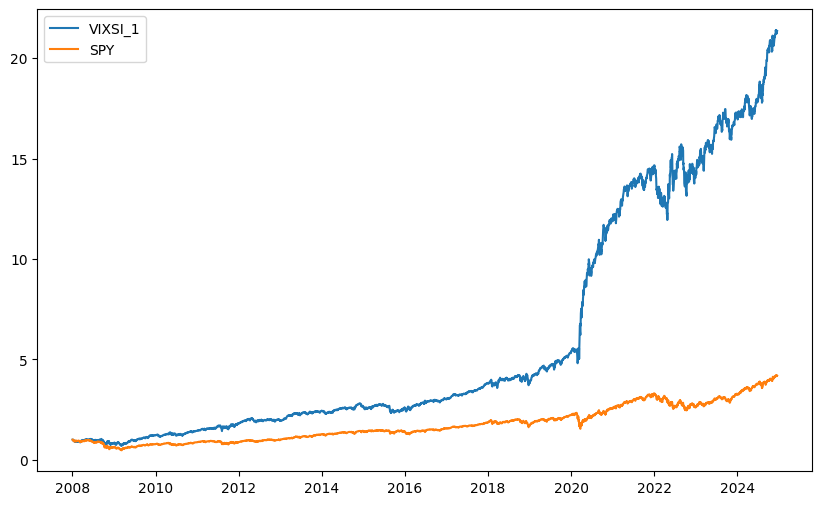

In [4]:

ret_ann, ret_ann_b, r_sharpe, r_sharpe_b = metrica_cartera(datos.estrategia1, datos.benchmark)
maxdwn, *_ = drwdown (datos.estrategia1)
maxdwn_b, *_ = drwdown (datos.SPY)

estrategias = ["VIXSI_1", "HOLD"]
valores = [[ret_ann, r_sharpe, maxdwn], [ret_ann_b, r_sharpe_b, maxdwn_b]]
df_result = pd.DataFrame(valores, index= estrategias)
df_result.columns = ["RetAnual","RSharpe","MaxDwd"]

plt.figure(figsize=(10,6))
plt.plot(datos.estrategia1, label='VIXSI_1')
plt.plot(datos.benchmark, label='SPY')

plt.legend()
plt.plot()
plt.savefig('estrategia1.png')

df_result = df_result.round(2)
df_result.to_clipboard()
df_result

### Comparación de la estrategia2 con SPY

,RetAnual,RSharpe,MaxDwd
VIXSI_2,0.14,0.72,0.43
HOLD,0.09,0.42,0.53


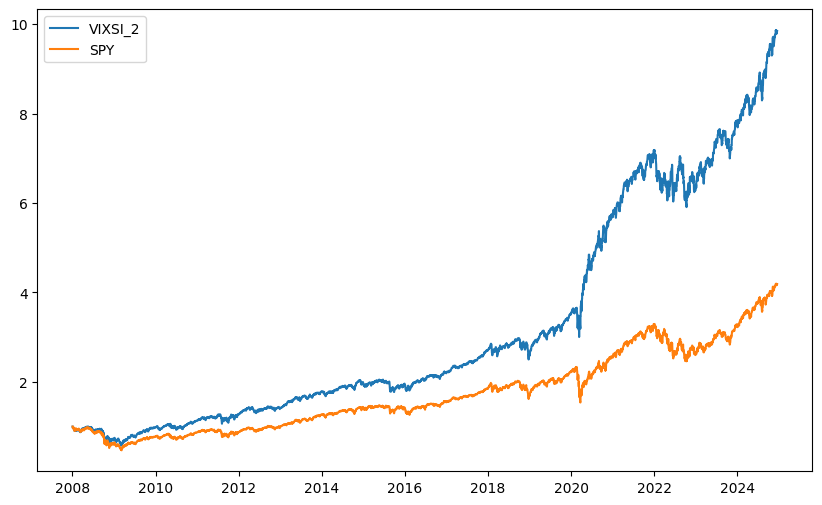

In [5]:

ret_ann, ret_ann_b, r_sharpe, r_sharpe_b = metrica_cartera(datos.estrategia2, datos.benchmark)
maxdwn, *_ = drwdown (datos.estrategia2)
maxdwn_b, *_ = drwdown (datos.SPY)

estrategias = ["VIXSI_2", "HOLD"]
valores = [[ret_ann, r_sharpe, maxdwn], [ret_ann_b, r_sharpe_b, maxdwn_b]]
df_result = pd.DataFrame(valores, index= estrategias)
df_result.columns = ["RetAnual","RSharpe","MaxDwd"]

plt.figure(figsize=(10,6))
plt.plot(datos.estrategia2, label='VIXSI_2')
plt.plot(datos.benchmark, label='SPY')

plt.legend()
plt.plot()
plt.savefig('estrategia2.png')

df_result = df_result.round(2)
df_result.to_clipboard()
df_result

### Conclusiones

Las dos estrategias mejoran al SPY en los tres indicadores (retorno anual, ratio sharpe y max.drawdown). De las dos variantes, la que tiene un mejor comportamiento es la que opera en corto, esta estrategia es la que se va a utilizar como cobertuara al SPY.
